In [11]:
import os
import math
import sys
import numpy as np
import matplotlib.pyplot as plt
import brighteyes_ism.simulation.PSF_sim as sim
import brighteyes_ism.analysis.Graph_lib as gra
import brighteyes_ism.analysis.Tools_lib as tool
import brighteyes_ism.analysis.Deconv_lib as dec
import brighteyes_ism.analysis.FRC_lib as frc
import brighteyes_ism.simulation.Tubulin_sim as simTub
import lib as flim
import napari as nap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.filters import gaussian
path = '/home/lcuneo/Documents/PostDoc/VS_Code/Bufalino/Code/'
os.chdir(path)
from s2ISM.src.s2ism import s2ism as s2
from scipy.signal import convolve

In [2]:
# %% Set Plot parameters for figures
plt.close('all')

plt.rcParams['ps.fonttype'] = 42
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

In [3]:
wd_path = os.getcwd()
files_path = os.path.join(wd_path, 'files')
if not os.path.exists(files_path):
    os.makedirs(files_path)

In [4]:
# %% psf
b = np.finfo(float).eps

exPar = sim.simSettings()
exPar.na = 1.4   # numerical aperture
exPar.wl = 640   # wavelength [nm]
exPar.gamma = 45  # parameter describing the light polarization
exPar.beta = 90  # parameter describing the light polarization
exPar.n = 1.5
exPar.mask_sampl = 151

emPar = exPar.copy()
emPar.wl = 660

grid = sim.GridParameters()
grid.Nz = 1
grid.pxsizex = 40
grid.pxsizez = 720
grid.pxpitch = 75e3
grid.pxdim = 50e3
grid.N = 5
grid.Nx = 71

file_psf = os.path.join(files_path, 'PSFs.npy') 

if os.path.exists(file_psf):
    psf = np.load(file_psf)
else:
    psf = sim.SPAD_PSF_3D(grid, exPar, emPar,stack ='positive')[0]
    np.save(file_psf, psf)


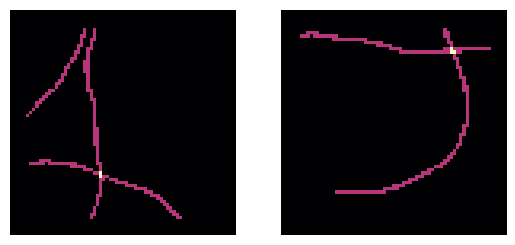

In [5]:
# %% phantom object
file_gt = os.path.join(files_path, 'simulated_tubulin_unmixing.npz')   

ntau = 2

if os.path.exists(file_gt):
    phTub = np.load(file_gt)['phantom']
else:
    tubulin = simTub.tubSettings()
    tubulin.xy_pixel_size = 60
    tubulin.xy_dimension = grid.Nx-10
    tubulin.xz_dimension = 1
    tubulin.z_pixel = 1
    tubulin.n_filament = 1
    tubulin.radius_filament = grid.pxsizex
    tubulin.intensity_filament = [1, 1]

    phTub = np.empty((ntau, tubulin.xy_dimension, tubulin.xy_dimension))

    for n in range(ntau):
        phTub[n] = np.squeeze(simTub.functionPhTub(tubulin))
        phTub[n] += np.squeeze(simTub.functionPhTub(tubulin)).T
        phTub[n] += np.fliplr(np.squeeze(simTub.functionPhTub(tubulin)))
        # phTub[n] += np.flipud(np.squeeze( simTub.functionPhTub(tubulin) ))
        # if n==0:
        # phTub[n] += np.fliplr(np.squeeze( simTub.functionPhTub(tubulin) ))
        # phTub[n] += np.flipud(np.squeeze( simTub.functionPhTub(tubulin) ))
        # phTub[n] += np.fliplr(np.squeeze( simTub.functionPhTub(tubulin) ))
        # phTub[n] += np.flipud(np.squeeze( simTub.functionPhTub(tubulin) ))
        # phTub[n] += np.fliplr(np.squeeze( simTub.functionPhTub(tubulin) ))
        # phTub[n] += np.flipud(np.squeeze( simTub.functionPhTub(tubulin) ))

    np.savez(file_gt, phantom=phTub, tub_settings=tubulin)
    
#%%
    
phTub = np.pad(phTub,((0,0),(5,5),(5,5)))


fig, ax = plt.subplots(1, ntau)
for tau in range(ntau):
    ax[tau].imshow(phTub[tau], cmap='magma')
    ax[tau].axis('off')
# %%

In [6]:
#%% Temporal functions
def rect(t, w):
    r = np.where(abs(t) <= w/2, 1, 0)*1.
    r /= r.sum()
    return r

def irf(t, w):
    r = np.where(abs(t-w/2) <= w/2, 1, 0)
    return r

def smooth_irf(t, s, w):
    irf_1 = rect(t, w)
    # g = gauss(t, 1, 0, t[len(t)//2], s)
    # irf_2 = convolve(irf_1, g, mode='same')
    dt = t[1] - t[0]
    irf_2 = gaussian(irf_1, s/dt)
    irf_2 /= irf_2.sum()
    return irf_2

def exp_decay(tau, t):
    decay = np.exp(-t/tau)
    decay[t < 0] = 0
    return decay


Text(0.5, 1.0, 'Ideal decay functions')

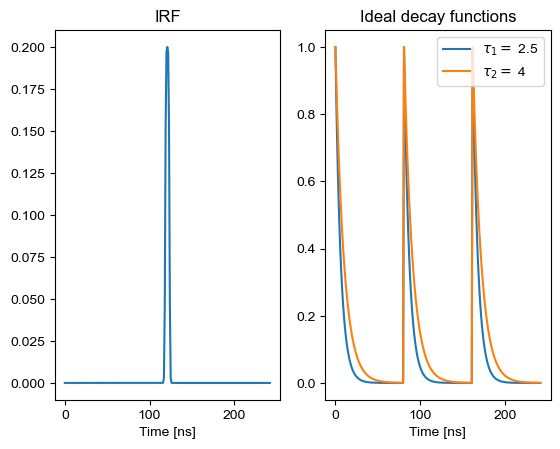

In [7]:
# %% Temporal decay
dt = 0.4  # ns
nbin = 81
window = 2.1  # ns
time = np.arange(3*nbin)*dt
t0 = time[len(time)//2]
# t0 = nbin*dt + 0
par = np.array([0.3, 2])
irf = smooth_irf(time - t0, *par)

# %%
flux = 1e3
ground_truth = phTub * flux

del phTub

#%%
tau_1 = 2.5  # ns
tau_2 = 4  # ns

period = nbin*dt
decay_1 = 0
decay_2 = 0

for tc in [-1, 0, 1]:
    decay_1 += exp_decay(tau_1, time-nbin*dt-tc*period)
    decay_2 += exp_decay(tau_2, time-nbin*dt-tc*period)


decay_w = np.stack((decay_1, decay_2))
del decay_1, decay_2

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(irf)
ax1.set_title('IRF')
ax1.set_xlabel('Time [ns]')
ax2.plot(decay_w[0], label=r'$\tau_1 = $ {}'.format(tau_1))
ax2.plot(decay_w[1], label=r'$\tau_2 = $ {}'.format(tau_2))
ax2.set_xlabel('Time [ns]')
ax2.legend()
ax2.set_title('Ideal decay functions')

Text(0.5, 1.0, 'Final decay functions')

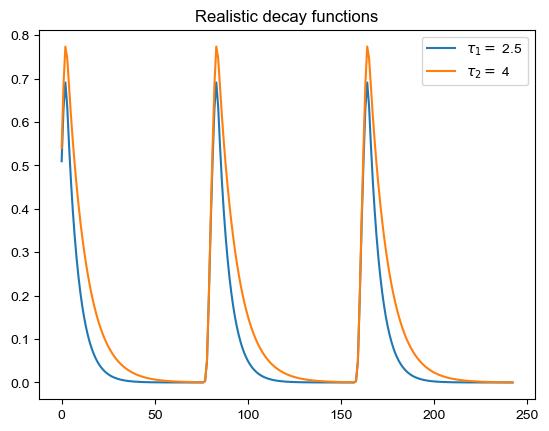

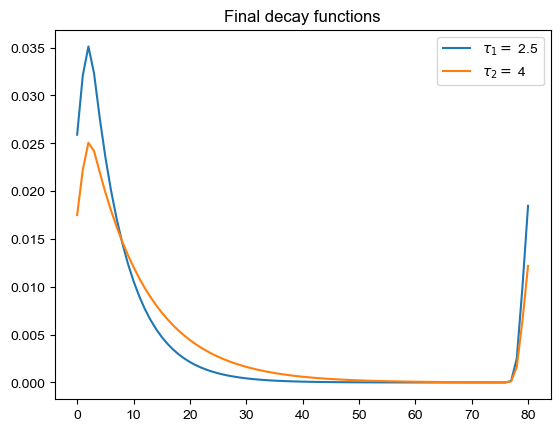

In [8]:
#%% dataset construction
irf_fin = np.empty((ntau,nbin*3))

for i in range(ntau):
    irf_fin[i] = convolve(decay_w[i], irf, mode='same')
     
#%%
plt.figure()
plt.plot(irf_fin[0], label=r'$\tau_1 = $ {}'.format(tau_1))
plt.plot(irf_fin[1], label=r'$\tau_2 = $ {}'.format(tau_2))
plt.legend()
plt.title('Realistic decay functions')


# %%
psf = np.squeeze(psf)
psf_fin = np.repeat(psf, 3*nbin).reshape((grid.Nx, grid.Nx, 25, 3*nbin))
psf_fin = np.einsum('ijkl , ml -> ijkml', psf_fin, irf_fin)

del irf_fin
irf = irf[nbin:-nbin]


# %% dataset creation
for i in range(ntau):
    psf_fin[:,:,:,i]/=psf_fin[:,:,:,i].sum()
    
Nx = grid.Nx
Nch = 5
dataset = np.empty([ntau, Nx, Nx, Nch**2, 3*nbin])

for i in range(Nch**2):
    for j in range(ntau):
        for l in range(nbin*3):
            dataset[j, :, :, i, l] = convolve(ground_truth[j,...], psf_fin[:,:,i,j,l], mode='same')

dataset[dataset < 0] = 0
d = dataset.sum(axis=0)

datafin = np.swapaxes(d,-2,-1)
del d

#%%
dataset_noise = np.random.poisson(datafin)
dataset_noise = np.swapaxes(dataset_noise,-1,-2)
del datafin

# %%
psf_fin = psf_fin[..., nbin:-nbin]
dataset_noise = dataset_noise[..., nbin:-nbin]
decay_1 = decay_w[0,..., nbin:-nbin]
decay_2 = decay_w[1,..., nbin:-nbin]

del decay_w

# %%
dataset_noise = np.swapaxes(dataset_noise,-1,-2)

#%%
psf_fin = np.swapaxes(psf_fin,-3,-1)  #(x y t tau nch)
psf_fin = np.swapaxes(psf_fin,0,-2)  #(tau y t x nch)
psf_fin = np.swapaxes(psf_fin,-3,-2)  #(tau y x t nch)
psf_fin = np.swapaxes(psf_fin,1,2)  #(tau x y t nch)

#%%
plt.figure()
plt.plot(np.sum(psf_fin[0],axis=(0,1,-1)), label=r'$\tau_1 = $ {}'.format(tau_1))
plt.plot(np.sum(psf_fin[1],axis=(0,1,-1)), label=r'$\tau_2 = $ {}'.format(tau_2))
plt.legend()
plt.title('Final decay functions')

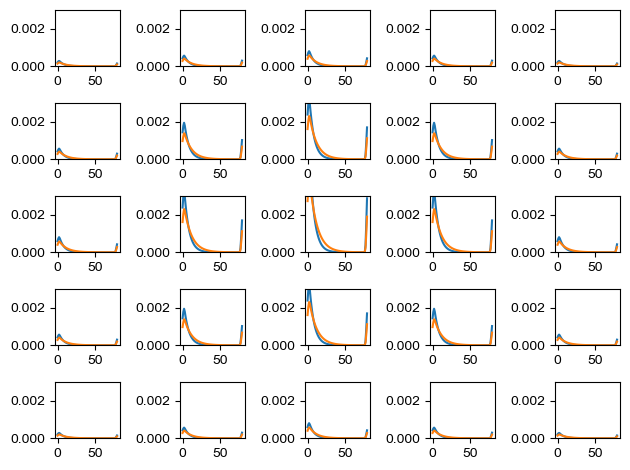

In [9]:
fig, ax = plt.subplots(5, 5)
for i in range(Nch):
    for j in range(Nch):
        ax[i,j].plot(np.sum(psf_fin[0, ..., i*Nch+j],axis=(0,1)), label=r'$\tau_1 = $ {}'.format(tau_1))
        ax[i,j].plot(np.sum(psf_fin[1, ..., i*Nch+j],axis=(0,1)), label=r'$\tau_2 = $ {}'.format(tau_2))
        ax[i,j].set_ylim([0,3e-3])
        #ax[i*Nch,j].legend()
        #ax[i,j].axis('off')
fig.tight_layout()

In [9]:
files_path_tau = os.path.join(files_path, r'tau{}_tau{}'.format(tau_1, tau_2))

if not os.path.exists(files_path_tau):
    os.makedirs(files_path_tau)

In [11]:
# %% Confocal case
data_clsm = dataset_noise.sum(-1)
psf_clsm = psf_fin.sum(-1)
data_clsm = data_clsm[..., None]
psf_clsm = psf_clsm[..., None]

# %%
n_iter = 200

file_rec = os.path.join(files_path_tau, 'confocal_recon_unmixing n_iter{}.npy'.format(n_iter))

if os.path.exists(file_rec):
    test = np.load(file_rec)
else:
    test = s2.max_likelihood_reconstruction(data_clsm, psf_clsm , max_iter=n_iter, rep_to_save ='all', initialization = 'sum')[0]
    np.save(file_rec, test)


Progress: 201it [00:24,  8.23it/s]                         


In [ ]:
inv = -1

fig, (ax1, ax2) = plt.subplots(1, 2)
im1 = ax1.imshow(test[inv,0])
ax1.set_title('First reconstruction')
fig.colorbar(im1, orientation='vertical')
im2=ax2.imshow(test[inv,1])
ax2.set_title('Second reconstruction')
fig.colorbar(im2, orientation='vertical')

In [ ]:
#%% PLOT
inv = -1

fig = plt.figure(figsize = (9, 9))
gs = fig.add_gridspec(8, 8)
#First row
ax1 = fig.add_subplot(gs[0:2, 0:2])
ax2 = fig.add_subplot(gs[0:2, 2:4])
#Second row
ax3 = fig.add_subplot(gs[2:4, 0:2])
ax4 = fig.add_subplot(gs[2:4, 2:4])
#Third row
ax5 = fig.add_subplot(gs[4:6, 0:2])
ax6 = fig.add_subplot(gs[4:6, 2:4])

t1=10

gra.ShowImg(data_clsm[...,t1,0], grid.pxsizex * 10e-3, fig = fig, ax = ax1)
ax1.set_title('Input Data at t = {}'.format(t1))
gra.ShowImg(data_clsm[...,:,0].sum(-1), grid.pxsizex * 10e-3, fig = fig, ax = ax2)
ax2.set_title('Input Data over t')
gra.ShowImg(test[inv,0], grid.pxsizex * 10e-3, fig = fig, ax = ax3)
ax3.set_title(r'Reconstructed Data $\tau = ${}'.format(tau_1))
gra.ShowImg(test[inv,1], grid.pxsizex * 10e-3, fig = fig, ax = ax4)
ax4.set_title(r'Reconstructed Data $\tau = ${}'.format(tau_2))
gra.ShowImg(ground_truth[0],1, fig = fig, ax = ax5)
ax5.set_title(r'GT Data $\tau = ${}'.format(tau_1))
gra.ShowImg(ground_truth[1],1, fig = fig, ax = ax6)
ax6.set_title(r'GT Data $\tau = ${}'.format(tau_2))
fig.tight_layout()

fig.suptitle('Confocal reconstruction', x=0.25, y=1.05, fontsize=16)
fig.savefig(os.path.join(files_path_tau, 'Confocal reconstruction n_iter{}.pdf'.format(n_iter)), dpi=900)
# %%{}'.format(tau_2)

# kl_tau_1 = tool.kl_divergence(ground_truth[0], tes[1:,0])
# kl_tau_2 = tool.kl_divergence(ground_truth[1], tes[1:,1])

# #%%
# plt.figure()
# plt.plot(kl_tau_1)
# plt.plot(kl_tau_2)

In [10]:
# %% ISM case
n_iter = 10

file_rec = os.path.join(files_path_tau,  'ISM_recon_unmixing_n_iter{}.npy'.format(n_iter))

if os.path.exists(file_rec):
   test_ism = np.load(file_rec)
else:
    test_ism = s2.max_likelihood_reconstruction(dataset_noise, psf_fin,
                                            max_iter=n_iter, rep_to_save ='all', initialization = 'flat')[0]
    np.save(file_rec, test_ism)


Progress: 11it [01:01,  5.59s/it]                        


In [12]:
print(dataset_noise.sum())
print(test_ism[-1].sum())

123212
123212.0


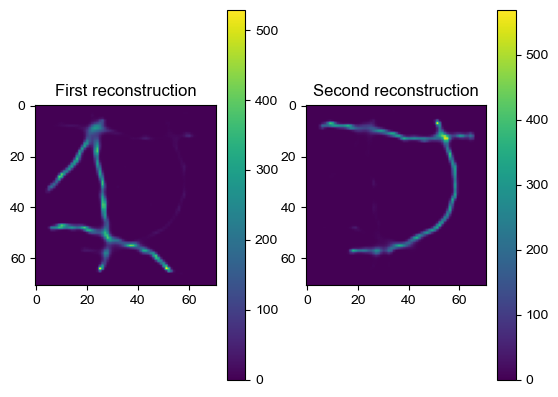

In [14]:
inv = -1
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
im1 = ax1.imshow(dataset_noise.sum(axis=(-2,-1)))
ax1.set_title('input summed over bins and channels')
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')
im2=ax2.imshow(test_ism[-1,0])
ax2.set_title('First reconstruction')
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im2, cax=cax2, orientation='vertical')
im3=ax3.imshow(test_ism[-1,1])
ax3.set_title('Second reconstruction')
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im3, cax=cax3, orientation='vertical')
fig.tight_layout()

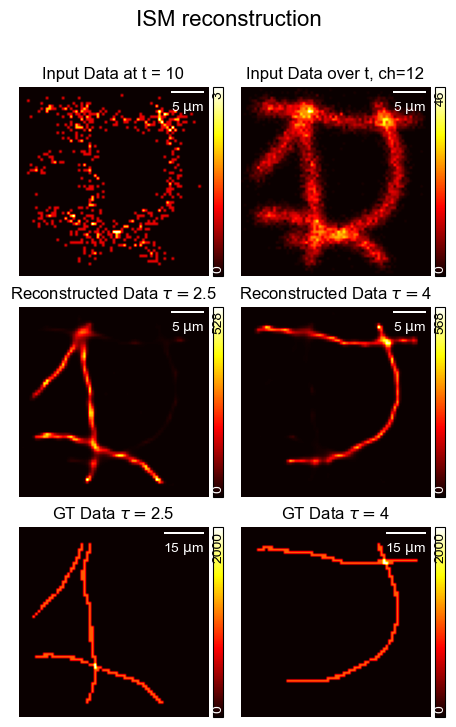

In [15]:
#%% PLOT
inv = -1

fig = plt.figure(figsize = (9, 9))
gs = fig.add_gridspec(8, 8)
#First row
ax1 = fig.add_subplot(gs[0:2, 0:2])
ax2 = fig.add_subplot(gs[0:2, 2:4])
#Second row
ax3 = fig.add_subplot(gs[2:4, 0:2])
ax4 = fig.add_subplot(gs[2:4, 2:4])
#Third row
ax5 = fig.add_subplot(gs[4:6, 0:2])
ax6 = fig.add_subplot(gs[4:6, 2:4])

t1=10

gra.ShowImg(dataset_noise[...,t1,12], grid.pxsizex * 10e-3, fig = fig, ax = ax1)
ax1.set_title('Input Data at t = {}'.format(t1))
gra.ShowImg(dataset_noise[...,:,12].sum(-1), grid.pxsizex * 10e-3, fig = fig, ax = ax2)
ax2.set_title('Input Data over t, ch=12')
gra.ShowImg(test_ism[inv,0], grid.pxsizex * 10e-3, fig = fig, ax = ax3)
ax3.set_title(r'Reconstructed Data $\tau = ${}'.format(tau_1))
gra.ShowImg(test_ism[inv,1], grid.pxsizex * 10e-3, fig = fig, ax = ax4)
ax4.set_title(r'Reconstructed Data $\tau = ${}'.format(tau_2))
gra.ShowImg(ground_truth[0],1, fig = fig, ax = ax5)
ax5.set_title(r'GT Data $\tau = ${}'.format(tau_1))
gra.ShowImg(ground_truth[1],1, fig = fig, ax = ax6)
ax6.set_title(r'GT Data $\tau = ${}'.format(tau_2))

fig.tight_layout()
fig.suptitle('ISM reconstruction', x=0.25, y=1.05, fontsize=16)
fig.savefig(os.path.join(files_path_tau, 'ISM reconstruction n_iter{}.pdf'.format(n_iter)), dpi=900)

# %%

# kl_tau_1 = tool.kl_divergence(ground_truth[0], tes[1:,0])
# kl_tau_2 = tool.kl_divergence(ground_truth[1], tes[1:,1])

# #%%
# plt.figure()
# plt.plot(kl_tau_1)
# plt.plot(kl_tau_2)